# Experiment 3: Minimum Neurons in Hidden Layer with parallel activation functions and complex output

## Objective
This experiment aims to determine the minimum number of neurons required in the hidden layer to achieve a mean absolute error than 0.009.
We are going to use parallel activation function to improve the performance

## Problem Specification
- **Input**: x, y coordinates
- **Output**: z = log(x² + y² + π)
- **Task**: Implementation of the Pythagorean theorem using a neural network

## Expected Outcome
The experiment will identify the optimal number of neurons needed in the hidden layer to accurately compute a complex output while maintaining a mean absolute error below 0.009.

Experimenting with networks for log(x² + y² + π) with MAE < 0.009

Testing network with 8 neurons and 1 layers
  Epoch 0: Val MAE: 1.363002, Test MAE: 1.385097
  Epoch 200: Val MAE: 0.020155, Test MAE: 0.018849
  Epoch 400: Val MAE: 0.013350, Test MAE: 0.012599
  Epoch 600: Val MAE: 0.011176, Test MAE: 0.010608
  Epoch 800: Val MAE: 0.011248, Test MAE: 0.010343
  Epoch 1000: Val MAE: 0.010268, Test MAE: 0.009480
✓ Target achieved with 8 neurons, 1 layers at epoch 1151
  Validation MAE: 0.008171, Test MAE: 0.007932

Prediction Examples:
  Input: (0.5, 0.5), Expected: 1.292421, Predicted: 1.301148, Error: 0.008726
  Input: (1.0, 0.0), Expected: 1.421080, Predicted: 1.398215, Error: 0.022866
  Input: (-0.3, 0.4), Expected: 1.221300, Predicted: 1.199455, Error: 0.021844
  Average Error: 0.017812

Activation Function Analysis:
----------------------------------------
      Tanh:   40.28%
 LeakyReLU:   29.15%
    Linear:   30.56%

Total weight magnitude: 1.148220

Testing network with 10 neu

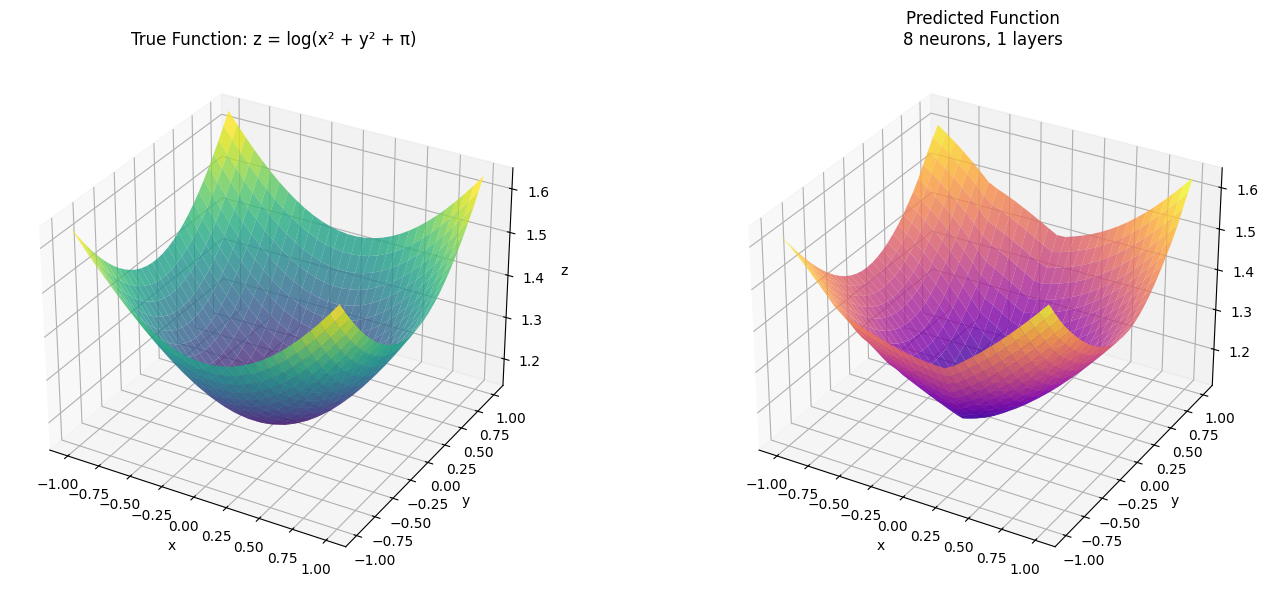

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

class TripleActivationNetwork(nn.Module):
    def __init__(self, hidden_size, layers=1):
        super(TripleActivationNetwork, self).__init__()
        
        # Input layer
        self.input = nn.Linear(2, hidden_size)
        
        # Three activation functions
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.identity = nn.Identity()  # Linear activation
        
        # Weights for combining activation functions (learnable)
        # One weight for each activation per neuron
        self.act_weights = nn.Parameter(torch.ones(3, hidden_size) / 3)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(layers-1):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Output layer
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Input layer
        x = self.input(x)
        
        # Apply weighted activations
        activated = (self.tanh(x) * self.act_weights[0].unsqueeze(0) + 
                     self.leaky_relu(x) * self.act_weights[1].unsqueeze(0) +
                     self.identity(x) * self.act_weights[2].unsqueeze(0))
        
        x = activated
        
        # Apply hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
            
            # Apply the same weighted activation pattern
            activated = (self.tanh(x) * self.act_weights[0].unsqueeze(0) + 
                         self.leaky_relu(x) * self.act_weights[1].unsqueeze(0) +
                         self.identity(x) * self.act_weights[2].unsqueeze(0))
            
            x = activated
        
        # Output layer
        return self.output(x)

def analyze_activations(model):
    # Get weights assigned to each activation function
    with torch.no_grad():
        weights = model.act_weights.detach().cpu()
        
        # Calculate importance of each activation
        activation_names = ['Tanh', 'LeakyReLU', 'Linear']
        importance = torch.mean(torch.abs(weights), dim=1)
        
        # Normalize to percentage
        total = torch.sum(importance)
        if total > 0:  # Avoid division by zero
            importance = 100 * importance / total
            
            print("\nActivation Function Analysis:")
            print("-" * 40)
            for i, name in enumerate(activation_names):
                print(f"{name:>10}: {importance[i].item():>7.2f}%")
                
            # Also show the raw total weight magnitude
            print(f"\nTotal weight magnitude: {total.item():.6f}")
        else:
            print("\nActivation Function Analysis:")
            print("-" * 40)
            print("All activation weights are zero")

def train_and_evaluate(hidden_size, layers=1, max_epochs=3000, threshold=0.009, lr=0.01):
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create model
    model = TripleActivationNetwork(hidden_size, layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Use L1Loss (MAE)
    criterion = nn.L1Loss()
    
    # Generate data for z = log(x² + y² + π)
    x_train = torch.FloatTensor(np.random.uniform(-1, 1, (4000, 2)))
    # Calculate x² + y² + π and apply log
    intermediate = x_train[:, 0]**2 + x_train[:, 1]**2 + math.pi
    y_train = torch.FloatTensor(np.log(intermediate)).reshape(-1, 1)
    
    # Validation data
    x_val = torch.FloatTensor(np.random.uniform(-1, 1, (1000, 2)))
    intermediate_val = x_val[:, 0]**2 + x_val[:, 1]**2 + math.pi
    y_val = torch.FloatTensor(np.log(intermediate_val)).reshape(-1, 1)
    
    # Test data
    x_test = torch.FloatTensor(np.random.uniform(-1, 1, (1000, 2)))
    intermediate_test = x_test[:, 0]**2 + x_test[:, 1]**2 + math.pi
    y_test = torch.FloatTensor(np.log(intermediate_test)).reshape(-1, 1)
    
    best_val_loss = float('inf')
    best_model_state = None
    patience = 50
    no_improve = 0
    
    train_losses = []
    val_losses = []
    test_losses = []
    
    # Training loop
    for epoch in range(max_epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Record training loss
        if epoch % 10 == 0:
            train_losses.append(loss.item())
        
        # Evaluate periodically
        if epoch % 10 == 0 or epoch == max_epochs - 1:
            model.eval()
            with torch.no_grad():
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss.item())
                
                test_outputs = model(x_test)
                test_loss = criterion(test_outputs, y_test)
                test_losses.append(test_loss.item())
                
                # Print progress occasionally
                if epoch % 200 == 0:
                    print(f"  Epoch {epoch}: Val MAE: {val_loss.item():.6f}, Test MAE: {test_loss.item():.6f}")
                
                # Track best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict().copy()
                    no_improve = 0
                else:
                    no_improve += 1
                
                # Check if we've met the threshold
                if val_loss < threshold and test_loss < threshold:
                    print(f"✓ Target achieved with {hidden_size} neurons, {layers} layers at epoch {epoch+1}")
                    print(f"  Validation MAE: {val_loss.item():.6f}, Test MAE: {test_loss.item():.6f}")
                    
                    # Load best model
                    if best_model_state:
                        model.load_state_dict(best_model_state)
                    
                    return {
                        'model': model,
                        'neurons': hidden_size,
                        'layers': layers,
                        'epochs': epoch+1,
                        'val_mae': val_loss.item(),
                        'test_mae': test_loss.item(),
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'test_losses': test_losses,
                        'success': True
                    }
                
                # Early stopping
                if no_improve >= patience and epoch > 500:
                    print(f"× Early stopping at epoch {epoch+1}")
                    print(f"  Best validation MAE: {best_val_loss:.6f}, Test MAE: {test_loss.item():.6f}")
                    
                    # Load best model
                    if best_model_state:
                        model.load_state_dict(best_model_state)
                    
                    return {
                        'model': model,
                        'neurons': hidden_size,
                        'layers': layers,
                        'epochs': epoch+1,
                        'val_mae': best_val_loss,
                        'test_mae': test_loss.item(),
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'test_losses': test_losses,
                        'success': False
                    }
    
    # Load best model before final evaluation
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    
    print(f"× Reached max epochs ({max_epochs})")
    print(f"  Best validation MAE: {best_val_loss:.6f}, Final test MAE: {test_loss.item():.6f}")
    
    return {
        'model': model,
        'neurons': hidden_size,
        'layers': layers,
        'epochs': max_epochs,
        'val_mae': best_val_loss,
        'test_mae': test_loss.item(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'success': False
    }

def test_model(model, num_points=3):
    # Define test points
    test_points = [
        [0.5, 0.5],    # Expected: log(0.5² + 0.5² + π) = log(0.5 + π)
        [1.0, 0.0],    # Expected: log(1.0² + 0.0² + π) = log(1 + π)
        [-0.3, 0.4],   # Expected: log((-0.3)² + 0.4² + π) = log(0.25 + π)
    ][:num_points]
    
    model.eval()
    with torch.no_grad():
        errors = []
        for point in test_points:
            x, y = point
            input_tensor = torch.FloatTensor([[x, y]])
            expected = math.log(x**2 + y**2 + math.pi)
            prediction = model(input_tensor).item()
            error = abs(prediction - expected)
            errors.append(error)
            
            print(f"  Input: ({x:.1f}, {y:.1f}), Expected: {expected:.6f}, Predicted: {prediction:.6f}, Error: {error:.6f}")
        
        avg_error = sum(errors) / len(errors)
        print(f"  Average Error: {avg_error:.6f}")
    
    return avg_error

def visualize_function(model, title=None):
    # Create a meshgrid for visualization
    x_range = np.linspace(-1, 1, 50)
    y_range = np.linspace(-1, 1, 50)
    X, Y = np.meshgrid(x_range, y_range)
    Z_true = np.log(X**2 + Y**2 + math.pi)
    
    # Get predictions from model
    model.eval()
    Z_pred = np.zeros_like(Z_true)
    with torch.no_grad():
        for i in range(len(x_range)):
            for j in range(len(y_range)):
                x_val = x_range[i]
                y_val = y_range[j]
                input_tensor = torch.FloatTensor([[x_val, y_val]])
                Z_pred[j, i] = model(input_tensor).item()
    
    # Compute error
    Z_error = np.abs(Z_true - Z_pred)
    
    # Create figure
    fig = plt.figure(figsize=(18, 6))
    
    # Plot true function
    ax1 = fig.add_subplot(131)
    c1 = ax1.contourf(X, Y, Z_true, 50, cmap='viridis')
    plt.colorbar(c1, ax=ax1, label='z = log(x² + y² + π)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('True Function')
    
    # Plot predicted function
    ax2 = fig.add_subplot(132)
    c2 = ax2.contourf(X, Y, Z_pred, 50, cmap='viridis')
    plt.colorbar(c2, ax=ax2, label='Predicted')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    if title:
        ax2.set_title(f'Predicted: {title}')
    else:
        ax2.set_title('Predicted Function')
    
    # Plot error
    ax3 = fig.add_subplot(133)
    c3 = ax3.contourf(X, Y, Z_error, 50, cmap='hot')
    plt.colorbar(c3, ax=ax3, label='Absolute Error')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('Prediction Error')
    
    plt.tight_layout()
    return fig

# Try different sizes of networks for the log function
print("Experimenting with networks for log(x² + y² + π) with MAE < 0.009")
print("=" * 70)

# Try different numbers of neurons, starting with configurations that worked well for the simpler function
neuron_configs = [8, 10, 15, 20]
layer_configs = [1, 2]

results = []

for layers in layer_configs:
    for neurons in neuron_configs:
        print(f"\nTesting network with {neurons} neurons and {layers} layers")
        result = train_and_evaluate(neurons, layers)
        
        print("\nPrediction Examples:")
        avg_error = test_model(result['model'])
        result['avg_error'] = avg_error
        
        # Analyze which activation functions were most important
        analyze_activations(result['model'])
        
        results.append(result)
        
        # Visualize the function approximation
        fig = visualize_function(result['model'], 
                                f"{neurons} neurons, {layers} layers")
        plt.savefig(f"log_function_{neurons}n_{layers}l.png")
        plt.close(fig)
        
        # If we've found a successful model with good error, we can stop
        if result['success'] and avg_error < 0.009:
            print("\n✓ Found excellent configuration")
            break
    
    # If we found a successful model in this layer configuration, break out of layer loop
    if any(r['success'] for r in results if r['layers'] == layers):
        break

# Show summary of all configurations
print("\n" + "=" * 90)
print("Configuration Results (sorted by validation MAE):")
print("-" * 90)
print(f"{'Neurons':^8} | {'Layers':^8} | {'Epochs':^8} | {'Val MAE':^10} | {'Test MAE':^10} | {'Avg Error':^10} | {'Success':^10}")
print("-" * 90)

# Sort by validation MAE (best first)
for r in sorted(results, key=lambda x: x['val_mae']):
    print(f"{r['neurons']:^8} | {r['layers']:^8} | {r['epochs']:^8} | " +
         f"{r['val_mae']:.6f} | {r['test_mae']:.6f} | {r['avg_error']:.6f} | {'✓' if r['success'] else '×'}")

# Find the best configuration by validation MAE
best_config = min(results, key=lambda x: x['val_mae'])

print("\nBest Overall Configuration:")
print(f"- Network for log(x² + y² + π) with {best_config['neurons']} neurons and {best_config['layers']} layers")
print(f"- Trained for {best_config['epochs']} epochs")
print(f"- Validation MAE: {best_config['val_mae']:.6f}, Test MAE: {best_config['test_mae']:.6f}")
print(f"- Average prediction error: {best_config['avg_error']:.6f}")
print(f"- Success: {'Yes' if best_config['success'] else 'No'}")

# Analyze the best model's activation functions
print("\nActivation analysis for the best model:")
analyze_activations(best_config['model'])

# Create a 3D surface plot comparison
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 6))

# True function
ax1 = fig.add_subplot(121, projection='3d')
x_range = np.linspace(-1, 1, 30)
y_range = np.linspace(-1, 1, 30)
X, Y = np.meshgrid(x_range, y_range)
Z_true = np.log(X**2 + Y**2 + math.pi)

ax1.plot_surface(X, Y, Z_true, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('True Function: z = log(x² + y² + π)')

# Predicted function
ax2 = fig.add_subplot(122, projection='3d')
Z_pred = np.zeros_like(Z_true)
with torch.no_grad():
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            x_val = x_range[i]
            y_val = y_range[j]
            input_tensor = torch.FloatTensor([[x_val, y_val]])
            Z_pred[j, i] = best_config['model'](input_tensor).item()

ax2.plot_surface(X, Y, Z_pred, cmap='plasma', alpha=0.8)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title(f'Predicted Function\n{best_config["neurons"]} neurons, {best_config["layers"]} layers')

plt.tight_layout()
plt.savefig("log_function_3d_comparison.png")
plt.show()

# Conclusion
1. It so cool it learns this complex function with just 8 neurons and 1 layer.